<a href="https://colab.research.google.com/github/NguyenVanVuong613/Finetune_SAM2/blob/main/Finetune_SAM2_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/sam2_train.zip -d /content/new_data

In [2]:
!git clone https://github.com/sagieppel/fine-tune-train_segment_anything_2_in_60_lines_of_code.git

Cloning into 'fine-tune-train_segment_anything_2_in_60_lines_of_code'...
remote: Enumerating objects: 383, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 383 (delta 63), reused 51 (delta 51), pack-reused 284 (from 1)
Receiving objects: 100% (383/383), 43.10 MiB | 22.32 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [2]:
%cd /content/fine-tune-train_segment_anything_2_in_60_lines_of_code

/content/fine-tune-train_segment_anything_2_in_60_lines_of_code


In [ ]:
#!pip install hydra-core

In [ ]:
!pip install -e .

In [ ]:
#using this command if !pip install -e . not working
!pip install --no-build-isolation -e .

Train Code

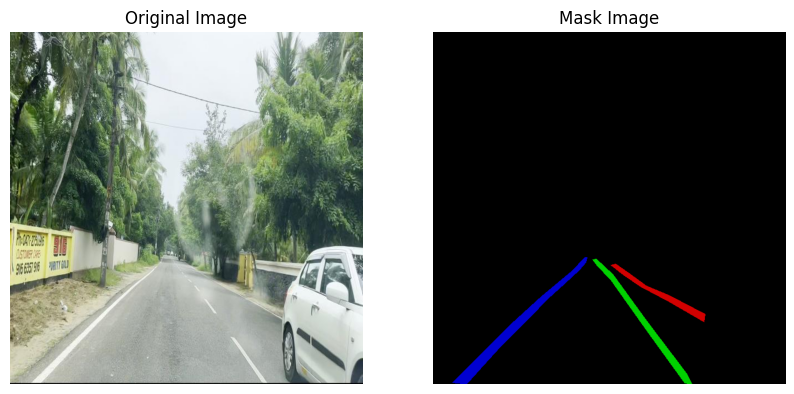

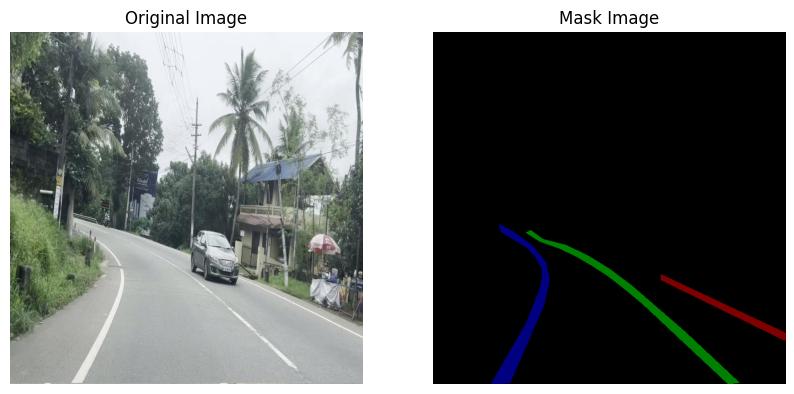

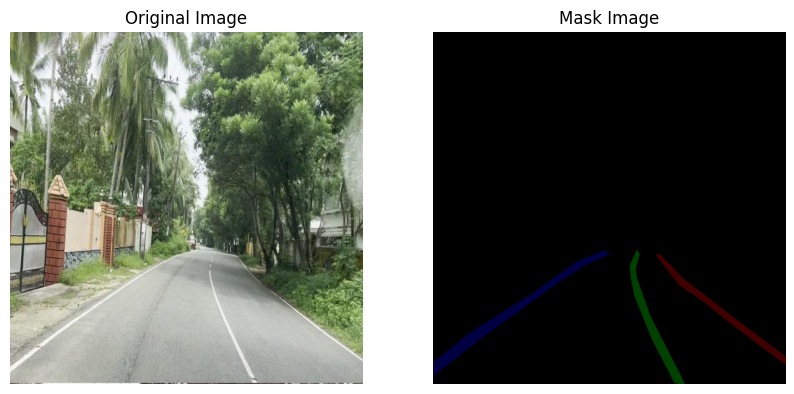

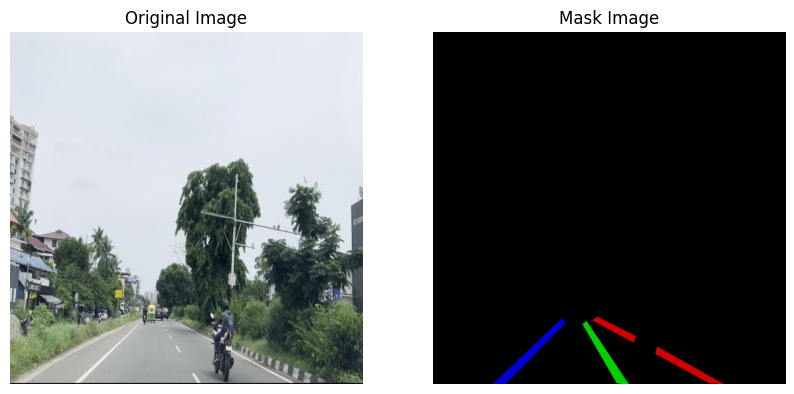

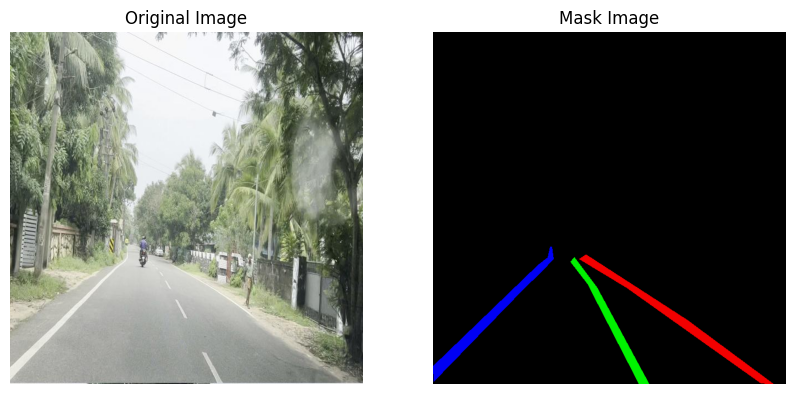

In [11]:
!pip install matplotlib
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

image_folder = '/content/new_data/sam2_train/image'
mask_folder = '/content/new_data/sam2_train/instance'
image_files = os.listdir(image_folder)

# Number of random images you want to display
num_images = 5

for _ in range(num_images):
    # Select a random image
    random_image = random.choice(image_files)

    # Construct the corresponding mask filename
    # Removing '_mask' from the file name
    mask_filename = random_image.replace('.jpg', '.png')  # Adjust extension if needed

    # Load the images
    img_path = os.path.join(image_folder, random_image)
    mask_path = os.path.join(mask_folder, mask_filename)

    # Check if the mask file exists
    if not os.path.exists(mask_path):
        print(f"Mask file not found: {mask_path}")
        continue

    # Open images using PIL
    img = Image.open(img_path)
    mask = Image.open(mask_path)

    # Plotting the images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Mask Image')
    plt.imshow(mask)
    plt.axis('off')

    plt.show()

In [8]:
# Train/Fine-Tune SAM 2 on the LabPics 1 dataset

# Toturial: https://medium.com/@sagieppel/train-fine-tune-segment-anything-2-sam-2-in-60-lines-of-code-928dd29a63b3
# Main repo: https://github.com/facebookresearch/segment-anything-2
# Labpics Dataset can be downloaded from: https://zenodo.org/records/3697452/files/LabPicsV1.zip?download=1
# Pretrained models for sam2 Can be downloaded from: https://github.com/facebookresearch/segment-anything-2?tab=readme-ov-file#download-checkpoints

import numpy as np
import torch
import cv2
import os
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Read data

data_dir=r"/content/new_data/sam2_train/" # Path to dataset (LabPics 1)
data=[] # list of files in dataset
for ff, name in enumerate(os.listdir(data_dir+"image/")):  # go over all folder annotation
    data.append({"image":data_dir+"image/"+name,"annotation":data_dir+"instance/"+name[:-4]+".png"})


def read_batch(data): # read random image and its annotaion from  the dataset (LabPics)

   #  select image

        ent  = data[np.random.randint(len(data))] # choose random entry
        Img = cv2.imread(ent["image"])[...,::-1]  # read image
        ann_map = cv2.imread(ent["annotation"]) # read annotation

   # resize image

        r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]]) # scalling factor
        Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
        ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)),interpolation=cv2.INTER_NEAREST)

   # merge vessels and materials annotations

        hacto_map = ann_map[:,:,0] # material annotation map
        tebaoday_map = ann_map[:,:,1] # vessel  annotaion map
        tebaovay_map = ann_map[:,:,2]
        # Initialize combined map with class 1 values
        combined_map = np.copy(hacto_map)

# Update combined map with class 2 values where class 1 is not present
        combined_map[hacto_map == 0] = tebaoday_map[hacto_map == 0] + (hacto_map.max() + 1)

# Update combined map with class 3 values where class 1 and class 2 are not present
        combined_map[(combined_map == hacto_map.max() + 1) & (tebaoday_map != 0)] = tebaovay_map[(combined_map == hacto_map.max() + 1) & (tebaoday_map != 0)] + (tebaovay_map.max() + 1)


   # Get binary masks and points

        inds = np.unique(combined_map)[1:] # load all indices
        points= []
        masks = []
        for ind in inds:
            mask=(combined_map == ind).astype(np.uint8) # make binary mask corresponding to index ind
            masks.append(mask)
            coords = np.argwhere(mask > 0) # get all coordinates in mask
            yx = np.array(coords[np.random.randint(len(coords))]) # choose random point/coordinate
            points.append([[yx[1], yx[0]]])
        return Img,np.array(masks),np.array(points), np.ones([len(masks),1])

# Load model

sam2_checkpoint = "/content/fine-tune-train_segment_anything_2_in_60_lines_of_code/checkpoints/sam2_hiera_tiny.pt" # path to model weight (pre model loaded from: https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt)
model_cfg = "//content//fine-tune-train_segment_anything_2_in_60_lines_of_code//sam2_configs//sam2_hiera_t.yaml" #  model config
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda") # load model
predictor = SAM2ImagePredictor(sam2_model)

# Set training parameters

predictor.model.sam_mask_decoder.train(True) # enable training of mask decoder
predictor.model.sam_prompt_encoder.train(True) # enable training of prompt encoder
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=1e-5,weight_decay=4e-5)
scaler = torch.cuda.amp.GradScaler() # mixed precision

# Training loop

for itr in range(20000):
    with torch.cuda.amp.autocast(): # cast to mix precision
            image,mask,input_point, input_label = read_batch(data) # load data batch
            if mask.shape[0]==0: continue # ignore empty batches
            predictor.set_image(image) # apply SAM image encoder to the image

            # prompt encoding

            mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
            sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(points=(unnorm_coords, labels),boxes=None,masks=None,)

            # mask decoder

            batched_mode = unnorm_coords.shape[0] > 1 # multi object prediction
            high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
            low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),sparse_prompt_embeddings=sparse_embeddings,dense_prompt_embeddings=dense_embeddings,multimask_output=True,repeat_image=batched_mode,high_res_features=high_res_features,)
            prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])# Upscale the masks to the original image resolution

            # Segmentaion Loss caclulation

            gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
            prd_mask = torch.sigmoid(prd_masks[:, 0])# Turn logit map to probability map
            seg_loss = (-gt_mask * torch.log(prd_mask + 0.00001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean() # cross entropy loss

            # Score loss calculation (intersection over union) IOU

            inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
            iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
            score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
            loss=seg_loss+score_loss*0.05  # mix losses

            # apply back propogation

            predictor.model.zero_grad() # empty gradient
            scaler.scale(loss).backward()  # Backpropogate
            scaler.step(optimizer)
            scaler.update() # Mix precision

            if itr%1000==0: torch.save(predictor.model.state_dict(), "model.torch");print("save model")

            # Display results

            if itr==0: mean_iou=0
            mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
            print("step)",itr, "Accuracy(IOU)=",mean_iou)



Streaming output truncated to the last 5000 lines.
step) 14991 Accuracy(IOU)= 0.7308808000587342
step) 14992 Accuracy(IOU)= 0.7325529195254932
step) 14993 Accuracy(IOU)= 0.7309611902646254
step) 14994 Accuracy(IOU)= 0.7286282765221507
step) 14995 Accuracy(IOU)= 0.7291768836456927
step) 14996 Accuracy(IOU)= 0.7252091907465069
step) 14997 Accuracy(IOU)= 0.7260983804438086
step) 14998 Accuracy(IOU)= 0.7280948264775511
step) 14999 Accuracy(IOU)= 0.7294461542709726
save model
step) 15000 Accuracy(IOU)= 0.7301315470735845
step) 15001 Accuracy(IOU)= 0.7319237486678969
step) 15002 Accuracy(IOU)= 0.7316108929313248
step) 15003 Accuracy(IOU)= 0.7308240794465001
step) 15004 Accuracy(IOU)= 0.7306511327318156
step) 15005 Accuracy(IOU)= 0.7311493930662558
step) 15006 Accuracy(IOU)= 0.7295291634073294
step) 15007 Accuracy(IOU)= 0.7309606319222582
step) 15008 Accuracy(IOU)= 0.729584894488076
step) 15009 Accuracy(IOU)= 0.7298734981722845
step) 15010 Accuracy(IOU)= 0.7292629878638328
step) 15011 Accurac

In [10]:
import torch

# Load the model from .torch file
model = torch.load('/content/fine-tune-train_segment_anything_2_in_60_lines_of_code/model.torch')

# Save the model as .pt file
torch.save(model, '/content/fine-tune-train_segment_anything_2_in_60_lines_of_code/model.pt')

print("Model converted to .pt format successfully!")


Model converted to .pt format successfully!


In [17]:
# Step 1: Install required libraries
!pip install torch torchvision

# Step 2: Import necessary libraries
import torch
import torchvision
from sam2.build_sam import build_sam2 # Import the function to build your model
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Step 3: Load your model
model_path = '/content/fine-tune-train_segment_anything_2_in_60_lines_of_code/model.pt'  # Replace with your actual path
model_cfg = "//content//fine-tune-train_segment_anything_2_in_60_lines_of_code//sam2_configs//sam2_hiera_t.yaml" #  model config

# Build the SAM2 model
model = build_sam2(model_cfg, None, device="cuda") # Do not load the checkpoint during model building

# Load the state dictionary into the model
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)

# Create an instance of the predictor
predictor = SAM2ImagePredictor(model)

# Step 4: Set the model to evaluation mode
predictor.model.eval()

# Step 5: Print the model
print(predictor.model)

SAM2Base(
  (image_encoder): ImageEncoder(
    (trunk): Hiera(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      )
      (blocks): ModuleList(
        (0): MultiScaleBlock(
          (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (attn): MultiScaleAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (proj): Linear(in_features=96, out_features=96, bias=True)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): MLP(
            (layers): ModuleList(
              (0): Linear(in_features=96, out_features=384, bias=True)
              (1): Linear(in_features=384, out_features=96, bias=True)
            )
            (act): GELU(approximate='none')
          )
        )
        (1): MultiScaleBlock(
          (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      